In [ ]:
#hide
#all_slow

In [1]:
#hide
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade

# Training ResNet18-UNET

> Training notebook for this architecture.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/11_resnet18-UNET.ipynb)

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.all import *

import cv2
import fastai
import torch
import numpy as np
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import albumentations as alb
import segmentation_models_pytorch as smp

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cuda')

In [4]:
fastai.__version__, torch.__version__

('2.3.0', '1.7.1+cu101')

In [5]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [6]:
torch.cuda.empty_cache()

In [7]:
!nvidia-smi

Sun Apr 11 11:41:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   37C    P8    11W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

![UNET Architecture](../imgs/unet.png)

In [8]:
seed_everything()

## Data

In [9]:
cond = train_pivot[0] != -1 # no common hard negatives
df = train_pivot.loc[cond]
df.shape

(6666, 6)

## Small size training

In [10]:
# size = (224,1568)
size = (128,896)

### DataLoader

In [ ]:
def get_train_aug(height, width): 
    #alb.CropNonEmptyMaskIfExists(height, width, p=0.5), #added after stage-1
    first_step = alb.RandomCrop(height, width, p=1.0)
    
    second_step = alb.OneOf([alb.VerticalFlip(p=0.5),
                              alb.HorizontalFlip(p=0.5)
                             ], p=0.5)
    
    third_step = alb.OneOf([
        alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), 
                                     contrast_limit=(-0.2, 0.2), 
                                     brightness_by_max=True,
                                     p=0.5),
        alb.RandomGridShuffle(always_apply=False, p=0.5, grid=(1, 2))], p=0.5)
    
    # to do: try with grayscale imgs
    last_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step, second_step, third_step])

def get_valid_aug(height, width): 
    first_step = alb.RandomCrop(height, width)
    last_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step])

In [11]:
train_tfm = get_train_aug(*size)
valid_tfm = get_valid_aug(*size)

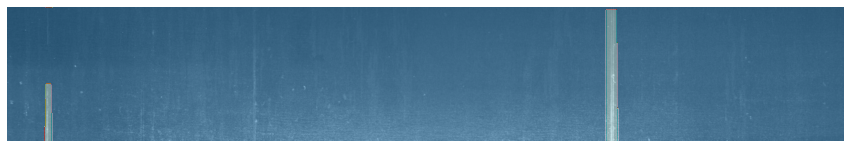

In [12]:
block = DataBlock(blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4],flatten_mask=False)),
                  get_x = ReadImagePathFromIndex,
                  get_y = ReadRLEs(cols=[1,2,3,4]),
                  splitter = TrainTestSplitter(test_size=0.2),
                  item_tfms=[AlbumentationsTransform(train_tfm, valid_tfm)],
                  batch_tfms=[Normalize.from_stats(*imagenet_stats)])

ds = block.datasets(df)

img, mask = ds[1]
ax = img.show(figsize=(15,5))
mask.show(ctx=ax);

In [13]:
dls = block.dataloaders(df, bs=4, num_workers=4, device=device)

In [20]:
dls = get_segmnt_dls(df, 
                     bs=4, 
                     train_aug=train_tfm, valid_aug=valid_tfm, 
                     device=device, 
                     flatten_mask=False)

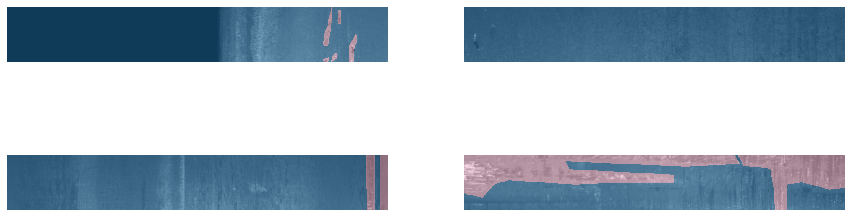

In [14]:
dls.show_batch(figsize=(15,5))

In [15]:
x, targ = dls.one_batch()
x.shape, targ.shape

(torch.Size([4, 3, 128, 896]), torch.Size([4, 4, 128, 896]))

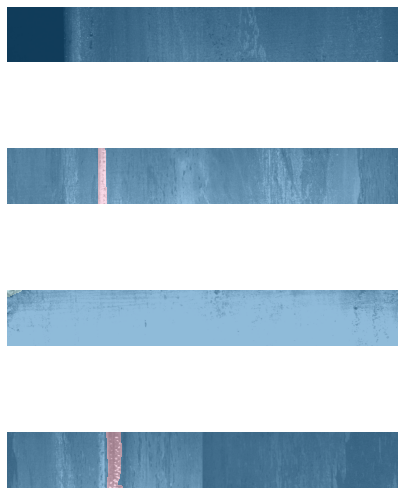

In [16]:
dls.show_batch(ncols=1, figsize=(7,10))

### Training

In [23]:
print_competition_data(models_dir)

../models/fastai-UNET-ResNet34-256-stage5.pth
../models/resnet18_class.pth
../models/resnet18-DynamicUNET-stage0.pth
../models/fastai-UNET-XResNeXt34-128x800.pth
../models/fastai-UNET-XResNeXt34-128x800-finetuning.pth
../models/.ipynb_checkpoints
../models/ResNet18-stage1-f1_0918.pth
../models/kaggle-UNET-ResNet34.pth
../models/ResNet18-encoder.pt
../models/logs
../models/kaggle-FPN-ResNet34.pth


In [17]:
fast_learner = unet_learner(dls=dls, 
                            arch=resnet18, 
                            loss_func=BCEWithLogitsLossFlat(),
                            metrics=[ModDiceMulti(), KaggleDice()], 
                            model_dir=models_dir, 
                            cbs=[CudaCallback(), ShowGraphCallback()]).to_fp16()

After training a multi label classification model with a `resnet18` encoder in [this notebook](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/_10_fastai.classifier.ipynb), I saved the encoder weights to load them in the UNET model to speedup training.

In [17]:
encoder_path = models_dir / "ResNet18-encoder.pt"
fast_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

Checking that is all right and freezed up to the encoder part of the network.

In [18]:
fast_learner.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 64 x 448   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=4.365158383734524e-05)

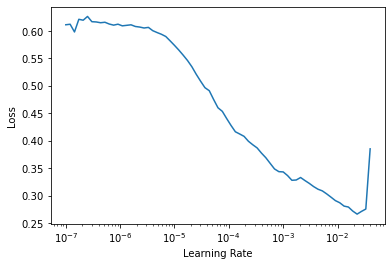

In [19]:
fast_learner.lr_find()

I chose the steepest point in the plot for the learning rate.

In [18]:
stage = "resnet18-DynamicUNET-stage0"

In [22]:
fit_cbs = [
    GradientAccumulation(n_acc=16),
    CSVLogger(fname=f'{models_dir}/logs/{stage}.csv'),
    SaveModelCallback(monitor='valid_loss', fname=stage)]

epoch,train_loss,valid_loss,mod_dice_multi,kaggle_dice,time
0,0.061103,0.047870,0.157363,0.163236,15:35
1,0.041372,0.034874,0.156614,0.216773,15:37
2,0.033654,0.027673,0.166384,0.289835,15:36
3,0.031238,0.026872,0.156865,0.289753,15:37
4,0.033279,0.026985,0.151454,0.291103,15:35
5,0.032202,0.026805,0.152661,0.291809,15:35


Better model found at epoch 0 with valid_loss value: 0.04787011817097664.


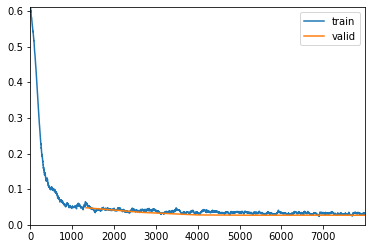

Better model found at epoch 1 with valid_loss value: 0.034874189645051956.
Better model found at epoch 2 with valid_loss value: 0.02767328917980194.
Better model found at epoch 3 with valid_loss value: 0.02687210962176323.
Better model found at epoch 5 with valid_loss value: 0.02680530771613121.


In [23]:
fast_learner.fit_one_cycle(6, lr_max=5e-5, cbs=fit_cbs)

Due to gpu hour limit, the following stage picks up where we left off. In the meantime I changed the dataloader augmentations adding `CropNonEmptyMaskIfExists` but the model is not learning anymore.

### Results

In [20]:
fast_learner = fast_learner.load(file=stage, device=device)
fast_learner.unfreeze()

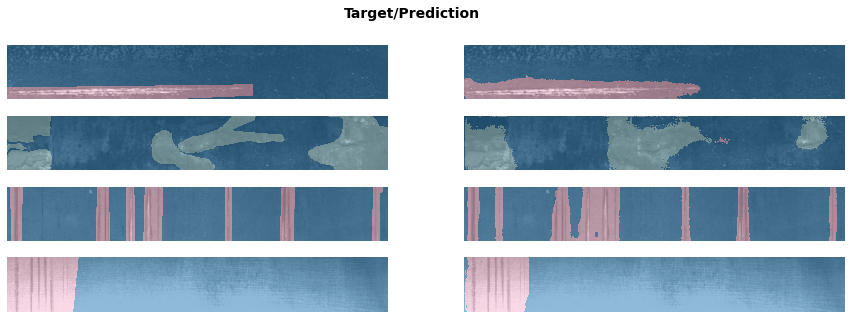

In [29]:
fast_learner.show_results(figsize=(15,5))

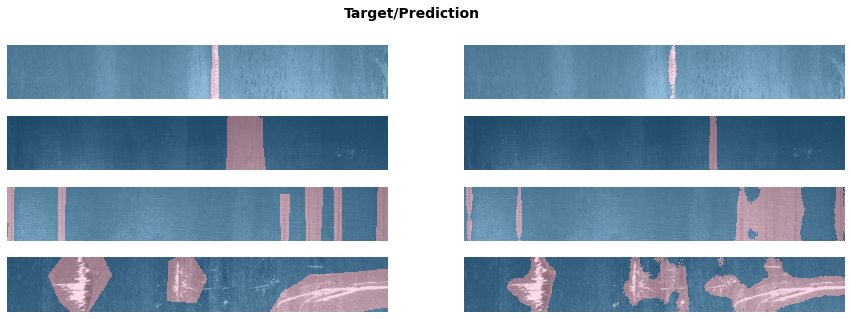

In [44]:
fast_learner.show_results(figsize=(15,5))

## Original size training

In [30]:
size = (224,1568)

In [36]:
def get_train_aug(height, width): 
    first_step = alb.RandomCrop(height, width, p=1.0)
    
    second_step = alb.OneOf([alb.VerticalFlip(p=0.5),
                              alb.HorizontalFlip(p=0.5)
                             ], p=0.5)
    
    # no RandomGridShuffle
    third_step = alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), 
                                     contrast_limit=(-0.2, 0.2), 
                                     brightness_by_max=True,
                                     p=0.5)
    
    # to do: try with grayscale imgs
    last_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step, second_step, third_step])

def get_valid_aug(height, width): 
    first_step = alb.RandomCrop(height, width)
    last_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step])

In [37]:
train_tfm = get_train_aug(*size)
valid_tfm = get_valid_aug(*size)

In [38]:
dls = get_segmnt_dls(df, 
                     bs=4, 
                     train_aug=train_tfm, valid_aug=valid_tfm, 
                     device=device, 
                     flatten_mask=False)

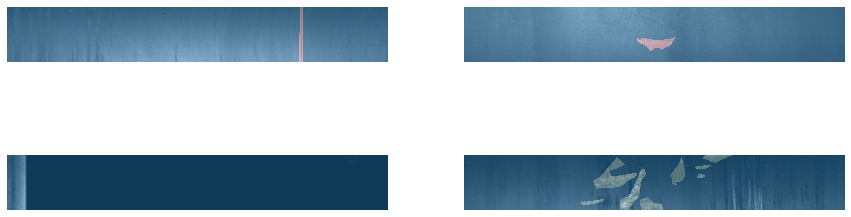

In [39]:
dls.show_batch(figsize=(15,5))

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=5.754399353463668e-06)

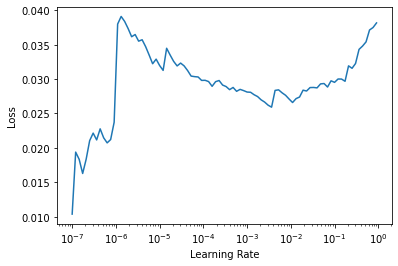

In [40]:
fast_learner.lr_find()

In [41]:
stage = "resnet18-DynamicUNET-stage1"

In [42]:
fit_cbs = [
    GradientAccumulation(n_acc=16),
    CSVLogger(fname=f'{models_dir}/logs/{stage}.csv'),
    SaveModelCallback(monitor='valid_loss', fname=stage)]

epoch,train_loss,valid_loss,mod_dice_multi,kaggle_dice,time
0,0.025173,0.023054,0.143275,0.288128,34:44
1,0.025168,0.022809,0.135827,0.286417,34:38
2,0.022334,0.022841,0.135430,0.286859,34:45
3,0.028812,0.022706,0.139297,0.292386,34:41


Better model found at epoch 0 with valid_loss value: 0.02305351011455059.


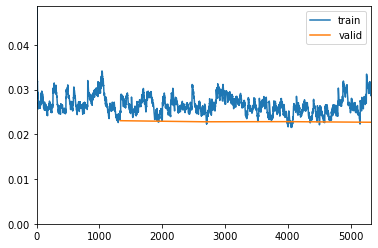

Better model found at epoch 1 with valid_loss value: 0.02280939742922783.
Better model found at epoch 3 with valid_loss value: 0.022706380113959312.


In [44]:
fast_learner.fit_one_cycle(4, lr_max=slice(3e-5, 3e-4), cbs=fit_cbs)